In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [262]:
df_TSLA=pd.read_csv('/Users/yangxiang/A List/Investment/Data/TSLA.csv')
df_AAPL=pd.read_csv('/Users/yangxiang/A List/Investment/Data/AAPL.csv')
df_BA=pd.read_csv('/Users/yangxiang/A List/Investment/Data/BA.csv')
df_SP500=pd.read_csv('/Users/yangxiang/A List/Investment/Data/S&P 500.csv')
df_NASDAQ=pd.read_csv('/Users/yangxiang/A List/Investment/Data/NASDAQ.csv')


In [263]:
#Set the time as the index
# convert to datetime
for i in [df_TSLA,df_AAPL,df_BA,df_SP500,df_NASDAQ]:
    i['Date'] = pd.to_datetime(i['Date'])
    i.set_index('Date', inplace=True)
#Only keep the adj close price
df_TSLA=df_TSLA[['Adj Close']]
df_AAPL=df_AAPL[['Adj Close']]
df_BA=df_BA[['Adj Close']]
df_SP500=df_SP500[['Adj Close']]
df_NASDAQ=df_NASDAQ[['Adj Close']]

# Join stock DataFrames and calculate returns
Our first step towards calculating modern portfolio theory (MPT) portfolios is to get daily and monthly returns. Eventually we're going to get the best portfolios of each month based on the Sharpe ratio. The easiest way to do this is to put all our stock prices into one DataFrame, then to resample them to the daily and monthly time frames. We need daily price changes to calculate volatility, which we will use as our measure of risk.

In [279]:


# Join 3 stock DataFrame together
full_df = pd.concat([df_TSLA, df_AAPL, df_BA], axis=1).dropna()

# Resample the full DataFrame to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly.tail())

            Adj Close  Adj Close  Adj Close
Date                                       
2020-05-01   0.456350   0.199909   0.020428
2020-06-01   0.280585   0.116412   0.135113
2020-07-01   0.246665   0.131303   0.191096
2020-08-03   0.326331   0.196754  -0.100100
2020-09-01   0.599495   0.233936   0.060578


In [314]:
# Create a dataframe for SP500 and NASDAQ
df_index=pd.concat([df_TSLA, df_AAPL, df_BA,df_SP500,df_NASDAQ], axis=1).dropna()
# Resample the full DataFrame to monthly timeframe
monthly_df_index = df_index.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily_index = df_index.pct_change()

# Calculate monthly returns of the stocks
returns_monthly_index = monthly_df_index.pct_change().dropna()
cols = []
count = 1
for column in returns_monthly_index.columns:
    if column == 'Adj Close':
        cols.append(f'Adj Close_{count}')
        count+=1
        continue
    cols.append(column)
returns_monthly_index.columns = cols

returns_monthly_index = returns_monthly_index[['Adj Close_4', 'Adj Close_5']]
returns_monthly_index=returns_monthly_index.rename(columns={"Adj Close_4": "SP500", "Adj Close_5": "NASDAQ"})
print(returns_monthly_index.tail())

               SP500    NASDAQ
Date                          
2020-05-01  0.145804  0.169059
2020-06-01  0.079492  0.110065
2020-07-01  0.019678  0.063084
2020-08-03  0.057368  0.073678
2020-09-01  0.070430  0.095101


,SP500,NASDAQ
Date,,
2010-07-01,-0.013321,-0.015839
2010-08-02,0.095866,0.092321
2010-09-01,-0.040476,-0.051635
2010-10-01,0.061048,0.089079
2010-11-01,0.033274,0.056560


# Calculate covariances for volatility

In MPT, we quantify risk via volatility. The math for calculating portfolio volatility is complex, and it requires daily returns covariances. We'll now loop through each month in the returns_monthly DataFrame, and calculate the covariance of the daily returns.

With pandas datetime indices, we can access the month and year with df.index.month and df.index.year. We'll use this to create a mask for returns_daily that gives us the daily returns for the current month and year in the loop. We then use the mask to subset the DataFrame like this: df[mask]. This gets entries in the returns_daily DataFrame which are in the current month and year in each cycle of the loop. Finally, we'll use pandas' .cov() method to get the covariance of daily returns.


In [267]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

           Adj Close  Adj Close  Adj Close
Adj Close   0.000509   0.001303   0.000501
Adj Close   0.001303   0.003594   0.001073
Adj Close   0.000501   0.001073   0.000665


# Calculate portfolios

We'll now generate portfolios to find each month's best one. numpy's random.random() generates random numbers from a uniform distribution, then we normalize them so they sum to 1 using the /= operator. We use these weights to calculate returns and volatility. Returns are sums of weights times individual returns. Volatility is more complex, and involves the covariances of the different stocks.

Finally we'll store the values in dictionaries for later use, with months' dates as keys.

In this case, we will only generate 10 portfolios for each date so the code will run faster, but in a real-world use-case you'd want to use more like 1000 to 5000 randomly-generated portfolios for a few stocks.

In [268]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(5000):
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize 
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)

print(portfolio_weights[date][0])

[0.38714477 0.53538979 0.07746544]


# Plot efficient frontier

We can finally plot the results of our MPT portfolios, which shows the "efficient frontier". This is a plot of the volatility vs the returns. This can help us visualize our risk-return possibilities for portfolios. The upper left boundary of the points is the best we can do (highest return for a given risk), and that is the efficient frontier.

To create this plot, we will use the latest date in our covariances dictionary which we created a few exercises ago. This has dates as keys, so we'll get the sorted keys using sorted() and .keys(), then get the last entry with Python indexing ([-1]). Lastly we'll use matplotlib to scatter variance vs returns and see the efficient frontier for the latest date in the data.



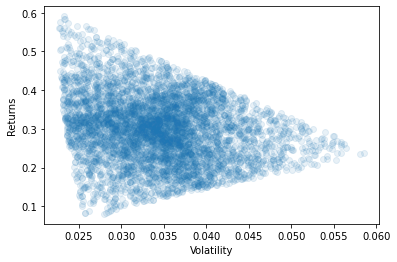

In [269]:
# Get latest date of available data
date = sorted(covariances.keys())[-1]  

# Plot efficient frontier
# warning: this can take at least 10s for the plot to execute...
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date], alpha=0.1)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

# Get best Sharpe ratios

We need to find the "ideal" portfolios for each date so we can use them as targets for machine learning. We'll loop through each date in portfolio_returns, then loop through the portfolios we generated with portfolio_returns[date]. We'll then calculate the Sharpe ratio, which is the return divided by volatility (assuming a no-risk return of 0).

We use enumerate() to loop through the returns for the current date (portfolio_returns[date]) and keep track of the index with i. Then we use the current date and current index to get the volatility of each portfolio with portfolio_volatility[date][i]. Finally, we get the index of the best Sharpe ratio for each date using np.argmax(). We'll use this index to get the ideal portfolio weights soon.




In [270]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]])

0.5909860086142246


# Calculate EWMAs

We will now work towards creating some features to be able to predict our ideal portfolios. We will simply use the price movement as a feature for now. To do this we will create a daily exponentially-weighted moving average (EWMA), then resample that to the monthly timeframe. Finally, we'll shift the monthly moving average of price one month in the future, so we can use it as a feature for predicting future portfolios.

In [271]:
# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean()

# Resample daily returns to first business day of the month with the first day for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

Adj Close    0.008447
Adj Close    0.010463
Adj Close   -0.003506
Name: 2020-09-01 00:00:00, dtype: float64


# Make features and targets

To use machine learning to pick the best portfolio, we need to generate features and targets. Our features were just created in the last exercise – the exponentially weighted moving averages of prices. Our targets will be the best portfolios we found from the highest Sharpe ratio.

We will use pandas' .iterrows() method to get the index, value pairs for the ewma_monthly DataFrame. We'll set the current value of ewma_monthly in the loop to be our features. Then we'll use the index of the best Sharpe ratio (from max_sharpe_idxs) to get the best portfolio_weights for each month and set that as a target.



In [272]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[0.15505262 0.82866899 0.01627839]
 [0.43501078 0.56301361 0.0019756 ]
 [0.05887784 0.36894679 0.57217537]
 [0.1238738  0.87305195 0.00307425]
 [0.97744668 0.02102852 0.0015248 ]]


# Plot efficient frontier with best Sharpe ratio

Let's now plot the efficient frontier again, but add a marker for the portfolio with the best Sharpe index. Visualizing our data is always a good idea to better understand it.

Recall the efficient frontier is plotted in a scatter plot of portfolio volatility on the x-axis, and portfolio returns on the y-axis. We'll get the latest date we have in our data from covariances.keys(), although any of the portfolio_returns, etc, dictionaries could be used as well to get the date. Then we get volatilities and returns for the latest date we have from our portfolio_volatility and portfolio_returns. Finally we get the index of the portfolio with the best Sharpe index from max_sharpe_idxs[date], and plot everything with plt.scatter().

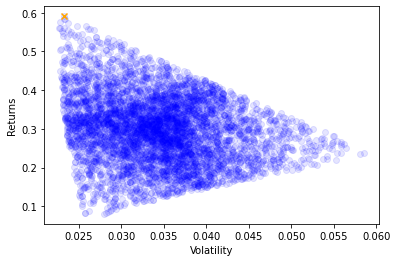

In [273]:
# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

# Plot efficient frontier with sharpe as point
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.1, color='blue')
best_idx = max_sharpe_idxs[date]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

# Make predictions with a random forest

In [274]:


from sklearn.ensemble import RandomForestRegressor


# Make train and test features
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.834020343524751
-0.24078499729425865


/Users/yangxiang/anaconda3/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/yangxiang/anaconda3/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multiout

# Get predictions and first evaluation
Now that we have a trained random forest model (rfr), we want to use it to get predictions on the test set. We do this to evaluate our model's performance – at a basic level, is it doing as well or better than just buying the index, SPY?


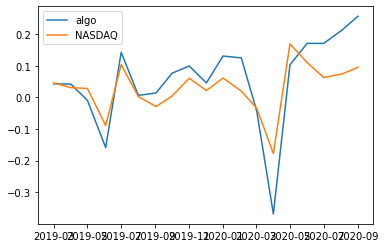

In [315]:
# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the NASDAQ returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly_index['NASDAQ'].iloc[train_size:], label='NASDAQ')
plt.legend()
plt.show()

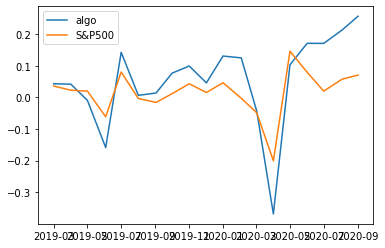

In [316]:
# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the S&P500 returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly_index['SP500'].iloc[train_size:], label='S&P500')
plt.legend()
plt.show()

# Evaluate returns

Let's now see how our portfolio selection would perform as compared with just investing in the SPY. We'll do this to see if our predictions are promising, despite the low R2
2
 value.

We will set a starting value for our investment of $1000, then loop through the returns from our predictions as well as from SPY. We'll use the monthly returns from our portfolio selection and SPY and apply them to our starting cash balance. From this we will get a month-by-month picture of how our investment is doing, and we can see how our predictions did overall vs the SPY. Next, we can plot our portfolio from our predictions and compare it to SPY.

In [317]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, spy_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly_index['SP500'].iloc[train_size:]:
    cash *= 1 + r
    spy_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('SPY returns:', (spy_cash[-1] - spy_cash[0]) / spy_cash[0])

algo returns: 1.309728293429094
SPY returns: 0.3030152498633149


# Plot returns



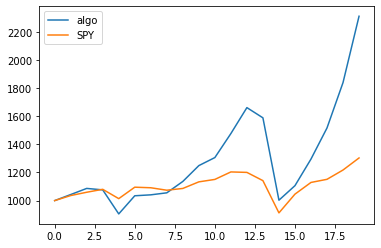

In [318]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash, label='algo')
plt.plot(spy_cash, label='SPY')
plt.legend()  # show the legend
plt.show()

# What's Next?


Tools for bigger data:
Python 3 multiprocessing
Dask
Spark
AWS or other cloud solutions

# Get more and better data
## Data in this course:
* From Quandl.com/EOD (free subset available)
## Alternative and other data:
* satellite images
* sentiment analysis (e.g. PsychSignal)
* analyst predictions
* fundamentals data